In [ ]:
%pip install -r requirements.txt

In [1]:
import pickle
import os
from ml_aspade import ml_aspade_train
from train_eval import train_and_save_model, evaluate_model


# Data Generation

In [ ]:
# nohup python training_data_gen_new.py --audio_dir speech_data --cnt 100 --train_dir train_data --test_dir test_data --output_path pkl_data --target_fs_values 16000 --clipping_thresholds 0.1 0.2 --time_clip 1 --K 16 --delta 300 > training_log.txt 2>&1 &


In [ ]:
!python training_data_gen_new.py \
    --audio_dir "speech_data" \
    --cnt 200 \
    --train_dir "train_data" \
    --test_dir "test_data" \
    --output_path "pkl_data" \
    --target_fs_values 16000 \
    --clipping_thresholds 0.1 0.2 \
    --time_clip 1 \
    --K 16 \
    --delta 300

In [ ]:
win_len = 250
win_shift = int(win_len / 4)

!python process.py --audio_dir custom_sound \
    --output_path output_sound \
    --time_clip 1 \
    --target_fs_values 16000 \
    --clipping_thresholds 0.2 \
    --dynamic 1 \
    --saving 0 \
    --plotting 0 \
    --delta 0 \
    --win_len {win_len} \
    --win_shift {win_shift}

In [ ]:
import pickle

# Path to your .pkl file
file_path = "/data2/AAG/MTech_Project_Second_Part/pkl_data/training_data.pkl"

# Load the pickle file
with open(file_path, "rb") as f:
    data = pickle.load(f)


Type of data: <class 'list'>
Unexpected data format: <class 'list'>


# Training

CUDA is available. Using GPU: NVIDIA GeForce RTX 3090
Training on cuda
Epoch 1/600, Loss: 18.1527, DFT Loss: 11.1799, Sparsity Loss: 6.9728
Epoch 2/600, Loss: 17.1351, DFT Loss: 10.4436, Sparsity Loss: 6.6915
Epoch 3/600, Loss: 16.6194, DFT Loss: 10.0734, Sparsity Loss: 6.5459
Epoch 4/600, Loss: 16.2651, DFT Loss: 9.8423, Sparsity Loss: 6.4227
Epoch 5/600, Loss: 16.0404, DFT Loss: 9.7175, Sparsity Loss: 6.3230
Epoch 6/600, Loss: 15.6988, DFT Loss: 9.4812, Sparsity Loss: 6.2176
Epoch 7/600, Loss: 15.4120, DFT Loss: 9.2829, Sparsity Loss: 6.1291
Epoch 8/600, Loss: 14.9837, DFT Loss: 8.9466, Sparsity Loss: 6.0371
Epoch 9/600, Loss: 14.6193, DFT Loss: 8.6659, Sparsity Loss: 5.9533
Epoch 10/600, Loss: 14.2588, DFT Loss: 8.3863, Sparsity Loss: 5.8725
Epoch 11/600, Loss: 13.8581, DFT Loss: 8.0634, Sparsity Loss: 5.7947
Epoch 12/600, Loss: 13.4630, DFT Loss: 7.7505, Sparsity Loss: 5.7125
Epoch 13/600, Loss: 13.1536, DFT Loss: 7.4989, Sparsity Loss: 5.6547
Epoch 14/600, Loss: 12.8854, DFT Loss:

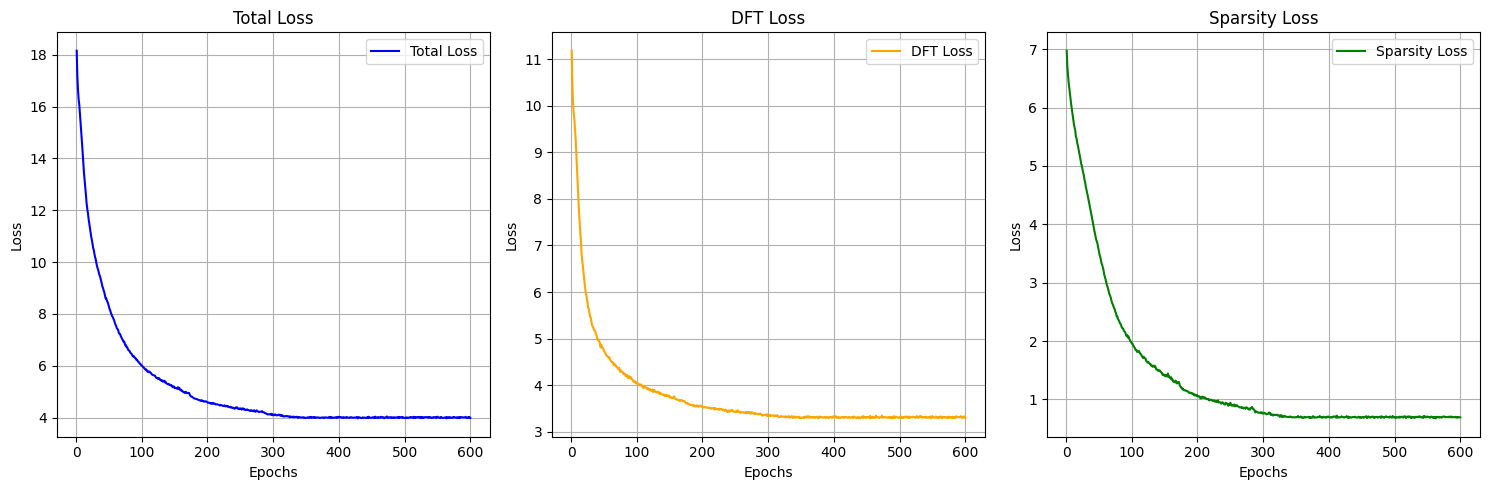

Model saved to complex_dft_model.pth


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from model_new import ComplexDFTAttentionModel, ComplexDFTDataset, train_complex_dft_model, save_model


# Set a fixed random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Create a model with frequency-aware attention
max_sparsity = 1000
model = ComplexDFTAttentionModel(dft_size=2000, max_sparsity=max_sparsity)

# Create dummy data for demonstration
batch_size = 8192
epochs = 600


import pickle

# Path to your .pkl file
file_path = "/data2/AAG/MTech_Project_Second_Part/pkl_data/training_data.pkl"

# Load the pickle file
with open(file_path, "rb") as f:
    data = pickle.load(f)


num_samples = len(data)

rp_in = []
rp_out = []
ip_in = []
ip_out = []
sp_out = []



for i in range(num_samples):
    rp_in.append(np.real(data[i][0]))
    rp_out.append(np.real(data[i][1]))
    ip_in.append(np.imag(data[i][0]))
    ip_out.append(np.imag(data[i][1]))
    sp_out.append(data[i][2])


# Combine real and imaginary into single vectors
inputs = np.concatenate([rp_in, ip_in], axis=1)
targets_dft = np.concatenate([rp_out, ip_out], axis=1)

# Ensure sparsity values are within range (0 to max_sparsity)
targets_sparsity = sp_out

# Create dataset and loader with explicit max_sparsity
train_dataset = ComplexDFTDataset(
    inputs=inputs,
    targets_dft=targets_dft,
    targets_sparsity=targets_sparsity,
    max_sparsity=max_sparsity
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Train the model with error handling
try:
    # First check if CUDA is available and print a helpful message
    if torch.cuda.is_available():
        print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("CUDA is not available. Using CPU.")
        
    train_complex_dft_model(model, train_loader, epochs=epochs)
except Exception as e:
    print(f"Training failed with error: {str(e)}")
    print("Try running with CPU only by forcing: device = torch.device('cpu')")

# Save the model
save_model(model, "complex_dft_model.pth")



# New model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Import classes from the previously shared code
# Assuming the code is saved as complex_dft_unet.py
from model_new_new import ComplexDFTUNet, ComplexDFTDataset, train_complex_dft_unet, save_model

# Set a fixed random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Create a model with frequency-aware attention
max_sparsity = 1000
model = ComplexDFTUNet(dft_size=2000, max_sparsity=max_sparsity)  # Using ComplexDFTUNet instead

# Create dummy data for demonstration
batch_size = 1024
epochs = 300

# Path to your .pkl file
file_path = "/data2/AAG/MTech_Project_Second_Part/pkl_data/training_data.pkl"

# Load the pickle file
with open(file_path, "rb") as f:
    data = pickle.load(f)

num_samples = len(data)

rp_in = []
rp_out = []
ip_in = []
ip_out = []
sp_out = []

for i in range(num_samples):
    rp_in.append(np.real(data[i][0]))
    rp_out.append(np.real(data[i][1]))
    # Fix: Use np.imag for imaginary parts
    ip_in.append(np.imag(data[i][0]))  
    ip_out.append(np.imag(data[i][1]))
    sp_out.append(data[i][2])

# Combine real and imaginary into single vectors
inputs = np.concatenate([rp_in, ip_in], axis=1)
targets_dft = np.concatenate([rp_out, ip_out], axis=1)

# Ensure sparsity values are within range (0 to max_sparsity)
targets_sparsity = sp_out

# Create dataset and loader with explicit max_sparsity
train_dataset = ComplexDFTDataset(
    inputs=inputs,
    targets_dft=targets_dft,
    targets_sparsity=targets_sparsity,
    max_sparsity=max_sparsity
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Train the model with error handling
try:
    # First check if CUDA is available and print a helpful message
    if torch.cuda.is_available():
        print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("CUDA is not available. Using CPU.")
        
    train_complex_dft_unet(model, train_loader, val_loader, epochs=epochs)  # Using train_complex_dft_unet instead
except Exception as e:
    print(f"Training failed with error: {str(e)}")
    print("Try running with CPU only by forcing: device = torch.device('cpu')")

# Save the model
save_model(model, "complex_dft_unet_model.pth")

CUDA is available. Using GPU: NVIDIA GeForce RTX 3090
Training on cuda
Using CustomFrequencyLoss
Error during training: mat1 and mat2 shapes cannot be multiplied (1024x256 and 512x512)


Traceback (most recent call last):
  File "/data2/AAG/MTech_Project_Second_Part/model_new_new.py", line 336, in train_complex_dft_unet
    pred_dft, pred_sparsity = model(inputs)
  File "/data2/AAG/MTech_Project_Second_Part/aagproj/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/data2/AAG/MTech_Project_Second_Part/aagproj/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
  File "/data2/AAG/MTech_Project_Second_Part/model_new_new.py", line 112, in forward
    a3 = self.attention3(e3, b)
  File "/data2/AAG/MTech_Project_Second_Part/aagproj/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/data2/AAG/MTech_Project_Second_Part/aagproj/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_

Model saved to complex_dft_unet_model.pth


# Evaluation

In [2]:
import pickle
import os
from ml_aspade import ml_aspade_train
from train_eval import train_and_save_model, evaluate_model
from model_new import ComplexDFTAttentionModel, load_model
import torch

sparsity_model_path = "complex_dft_model.pth"
test_audio_dir = "custom_sound"
output_dir = "/data2/AAG/MTech_Project_Second_Part/test_data_output"

target_fs_values = [16000]
clipping_thresholds = [0.2]
time_clip = [1]
max_sparsity = 1000
k_classes=100



loaded_model = load_model(ComplexDFTAttentionModel, sparsity_model_path)



# 1. Set device explicitly to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_model = loaded_model.to(device)

# Run evaluation
results_df, summary = evaluate_model(
    test_audio_dir=test_audio_dir,
    output_dir=output_dir,
    target_fs_values=target_fs_values,
    clipping_thresholds=clipping_thresholds,
    time_clip=time_clip,
    model_path=sparsity_model_path,
    loaded_model=loaded_model,
    device=device)

# Print summary statistics
print("\nEvaluation Summary:")
print(summary)


Processing files:   0%|          | 0/1 [00:00<?, ?it/s]


Processing: 6930-81414-0024.wav (fs=16000, threshold=0.2, duration=1)
Generating clipped signal...


/data2/AAG/MTech_Project_Second_Part/spade_segmentation.py:146: ComplexWarning: Casting complex values to real discards the imaginary part
  data_rec_fin[idx] = data_rec_fin[idx] + data_rec_block * gsyn
Processing files: 100%|██████████| 1/1 [00:17<00:00, 17.18s/it]



Final Results DataFrame:
                  file     fs  threshold  duration  sdr_original  \
0  6930-81414-0024.wav  16000        0.2         1      8.457121   

   sdr_reconstructed  sdr_improvement  processing_time  clipped_percentage  \
0          16.602137         8.145016        16.943473             6.60625   

     pesq_i    pesq_f  
0  1.775976  3.927773  

Summary Statistics:
                         sdr_improvement     processing_time  \
                                    mean std            mean   
fs    threshold duration                                       
16000 0.2       1                   8.15 NaN           16.94   

                         clipped_percentage pesq_i pesq_f  
                                       mean   mean   mean  
fs    threshold duration                                   
16000 0.2       1                      6.61   1.78   3.93  

Evaluation Summary:
                         sdr_improvement     processing_time  \
                             

# Git Push

In [1]:
!cd /data2/AAG/MTech_Project_Second_Part

In [2]:
!git init

Initialized empty Git repository in /data2/AAG/MTech_Project_Second_Part/.git/


In [8]:
!echo -e "*.wav\n*.pkl\n*.pth\n*.log\naagproj/\n__pycache__/\n*.pyc\n.env\n.DS_Store" > .gitignore

In [9]:
!cat .gitignore

*.wav
*.pkl
*.pth
*.log
aagproj/
__pycache__/
*.pyc
.env
.DS_Store


In [ ]:
!git reset
!git add .
!git commit -m "Initial backup (excluding .wav files)"
!git remote add origin https://github.com/AAG1201/MTech_Project_Second_Part.git
!git branch -M main
!git push -u origin main